# Subbundles Part 5: Clustering

**Subbundle** - a subgroup of streamlines with a set of common properties

In [1]:
import numpy as np
import pandas as pd

from pyclustertend import hopkins, assess_tendency_by_metric

from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

import scipy.cluster.hierarchy as spc
from scipy.cluster.hierarchy import dendrogram


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Streamline Profiles (from Part 3)

In [2]:
fa_values = np.load('streamline_profile_fa.npy')
md_values = np.load('streamline_profile_md.npy')

## Adjacencies (From Part 4)

In [3]:
adjacencies = [
    np.load('adjacency_fa.npy'),
    np.load('adjacency_r2.npy'),
    np.load('adjacency_md.npy'),
    np.load('adjacency_wt.npy'),
    np.load('adjacency_mdf.npy')
]

adjacencies_names = ['fa', 'r2', 'md', 'wt', 'mdf']

## Cluster Tendency Metrics

- Hopkins Statistics

Scores between 0 and 1, a score around 0.5 express no clusterability and a score tending to 0 express a high cluster tendency.

In [4]:
for name, adjacency in zip(adjacencies_names, adjacencies):
    print(f'{name} cluster tendency:', hopkins(adjacency, 100))

fa cluster tendency: 0.09987759808625774
r2 cluster tendency: 0.027839168959633547
md cluster tendency: 0.07388586576544215
wt cluster tendency: 0.07745440950732073
mdf cluster tendency: 0.03959802917711648



- Silhouette _(using Kmeans)_

Assumes a minimum of two clusters. 

Returns the recommended number of clusters based on silhoutte score, where the best score is 1 and worst is -1. Note that values near 0 indicate overlapping clusters.

In [5]:
for name, adjacency in zip(adjacencies_names, adjacencies):
    print(f'{name} cluster tendency (silhouette):', assess_tendency_by_metric(adjacency, "silhouette", 10))

fa cluster tendency (silhouette): (2, array([0.44424599, 0.36781438, 0.31068167, 0.32609082, 0.30655394,
       0.28960736, 0.27274267, 0.27447696, 0.2872468 ]))
r2 cluster tendency (silhouette): (2, array([0.59771279, 0.43775225, 0.47480841, 0.44332308, 0.48385429,
       0.4998962 , 0.4883411 , 0.46221103, 0.47065243]))
md cluster tendency (silhouette): (2, array([0.39221372, 0.34433621, 0.345446  , 0.29338205, 0.29262719,
       0.31420665, 0.32374312, 0.32989791, 0.33345583]))
wt cluster tendency (silhouette): (3, array([0.35834094, 0.37954206, 0.35016132, 0.31967158, 0.3297205 ,
       0.30074921, 0.30764361, 0.33306744, 0.31263325]))
mdf cluster tendency (silhouette): (7, array([0.40840836, 0.45078612, 0.42096054, 0.47788074, 0.48061939,
       0.50662795, 0.47634427, 0.46243005, 0.48120672]))


## Permute/reorder matrix by similarity

- this becomes convex optimization problem

- many clustering algorithms would work for this setup

### [Dimensionality Reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction)

Dimensionality reduction can be thought of as a neutral clustering model

### <span style="color:red">NOTE: There are many [dimensionality reduction techniques](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/) available to choose from.</span>

- <span style="color:red">**Question: Which others make sense to explore? and how to compare?**</span>


- [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (*Principle Component Analysis*)

### PCA

In [6]:
pcas = []

for name, adjacency in zip(adjacencies_names, adjacencies):
    pca = PCA(n_components=3)
    pca.fit(adjacency)
    pcas.append(pca)
    
#     print(f"{name} eigenvectors:\n", pca.components_.T)
#     print(f"{name} eigenvalues:\n", pca.explained_variance_)
#     print(f"{name} loadings:\n", pca.components_.T * np.sqrt(pca.explained_variance_))
#     print("\n")

#### NOTE that the eigenvectors are very short and hard to see in this

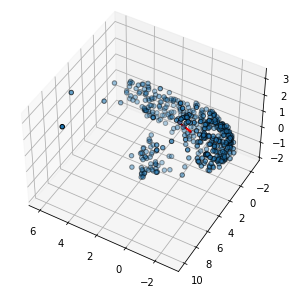

In [7]:
i = adjacencies_names.index('wt')

X = pcas[i].transform(adjacencies[i])

fig = plt.figure(figsize=(5, 5))

ax = Axes3D(fig, rect=[0, 0, 0.75, 1], elev=45, azim=120)
sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], edgecolor='k')

for v in pcas[i].components_:
    ax.quiver(
        pcas[i].mean_[0],  pcas[i].mean_[1],  pcas[i].mean_[2], # <-- starting point of vector
        v[0] - pcas[i].mean_[0], v[1] -  pcas[i].mean_[1], v[2] -  pcas[i].mean_[2], # <-- directions of vector
        arrow_length_ratio=0.1, color='red'
    )

#### WARNING: Using clustering results from below to color code clusters

## Clustering

- For every streamline assign class given collection in unsupervised manner

  - Then label clusters
    
    - To identify number of clusters use empirical test like F-test

- [Spectral Clustering](https://en.wikipedia.org/wiki/Spectral_clustering) in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

### Distribution model: Gaussian mixture models (GMM)

https://scikit-learn.org/stable/modules/mixture.html#mixture

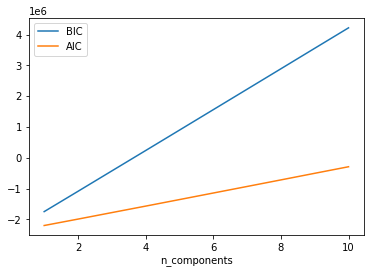

In [8]:
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(adjacencies[0]) for n in n_components]
plt.plot(n_components, [m.bic(adjacencies[0]) for m in models], label='BIC')
plt.plot(n_components, [m.aic(adjacencies[0]) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

### <span style="color:red">NOTE: Despite BIC and AIC results manually setting `n_components=3` to the desired number of clusters.</span>

In [9]:
gmm = GaussianMixture(n_components=3)
gmm_idxs = []

for name, adjacency in zip(adjacencies_names, adjacencies):
    gmm.fit(adjacency)
    idx = gmm.predict(adjacency)
    gmm_idxs.append(idx)
    np.save(f'gmm_{name}_idx.npy', idx)
    
    print(f'{name} silhouette score:', silhouette_score(adjacency, idx))

fa silhouette score: 0.2873644326671527
r2 silhouette score: 0.41848952038717885
md silhouette score: 0.3413630869869561
wt silhouette score: 0.3777982515618182
mdf silhouette score: 0.3551498910648991


### Centroid Model: MeanShift

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift

### <span style="color:red">NOTE: There is a `bandwidth` parameter taking default, so bandwidth is estimated using `sklearn.cluster.estimate_bandwidth`.</span>

In [10]:
ms = MeanShift()
ms_idxs = []

for name, adjacency in zip(adjacencies_names, adjacencies):
    idx = ms.fit(adjacency).labels_
    ms_idxs.append(idx)
    np.save(f'ms_{name}_idx.npy', idx)
    
    print(f'{name} silhouette score:', silhouette_score(adjacency, idx))

fa silhouette score: 0.44989320760941476
r2 silhouette score: 0.5345514790782278
md silhouette score: 0.37459521060671347
wt silhouette score: 0.2556579110601718
mdf silhouette score: 0.35991849132700277


### Connectivity Model: Hierarchical Clusters

Following example from:

https://stackoverflow.com/questions/52787431/create-clusters-using-correlation-matrix-in-python/52787518#52787518

Using [`scipy.cluster` Hierarchical Clustering package](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy)

- see https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy

### <span style="color:red">NOTE: The dendrogram can be used to manually tune the threshold to desired number of clusters.</span>

- Here setting `p` level to `1` since expect SLF bundle to have 2 or 3 subbundles

In [11]:
pdists = []
linkages = []

for name, adjacency in zip(adjacencies_names, adjacencies):
    # Pairwise distances between observations in n-dimensional space
    pdist = spc.distance.pdist(adjacency)
    pdists.append(pdist)

    # Perform hierarchical clustering
    linkage = spc.linkage(pdist, method='complete')
    linkages.append(linkage)

#     plt.figure()
#     plt.title(f'{name} dendrogram')
#     dendrogram(linkage, p=1, truncate_mode='level', show_leaf_counts=True)
#     plt.show()

### <span style="color:red">NOTE: Manually setting threshold based on dendrogram</span>

- However, it would be better to learn threshold

In [12]:
ratios = [8/12, 40/60, 18/35, 8/14, 200/240]

In [13]:
hier_idxs = []

for name, adjacency in zip(adjacencies_names, adjacencies):
    i = adjacencies_names.index(name)
    
    # Threshold to apply when forming flat clusters
    cluster_threshold = ratios[i] * pdists[i].max()

    # Forms flat clusters from the hierarchical clustering defined by the given linkage matrix
    # so that the original observations in each flat cluster have no greater a cophenetic distance 
    # than cluster_threshold
    idx = spc.fcluster(linkages[i], cluster_threshold, 'distance')
    hier_idxs.append(idx)
    np.save(f'hier_{name}_idx.npy', idx)
    
    print(f'{name} silhouette score:', silhouette_score(adjacency, idx))

#     print(f"{name} number of clusters:", len(np.unique(idx)))

fa silhouette score: 0.39167073785001744
r2 silhouette score: 0.5253343551583853
md silhouette score: 0.395290385125116
wt silhouette score: 0.3342529522172402
mdf silhouette score: 0.3199855208024445


## Resort the matrix based on cluster

In [15]:
dfs = [
    pd.DataFrame(fa_values.T),
    pd.DataFrame.from_records(adjacencies[1]),
    pd.DataFrame(md_values.T),
    pd.DataFrame.from_records(adjacencies[3]),
    pd.DataFrame.from_records(adjacencies[4])
]

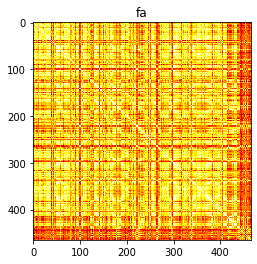

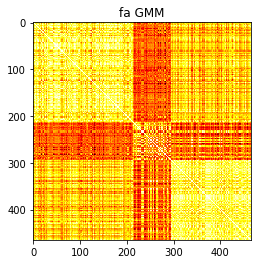

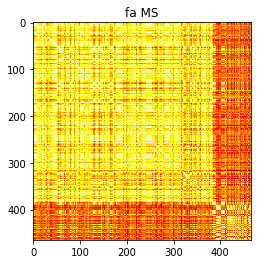

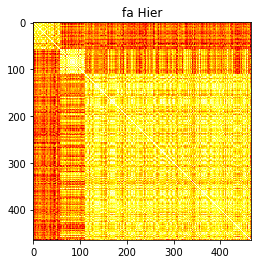

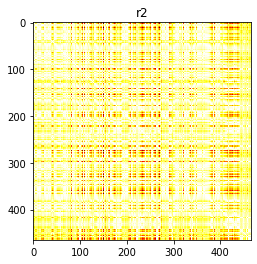

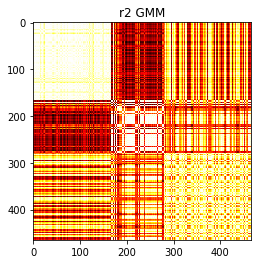

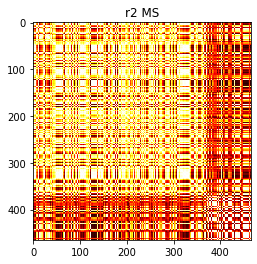

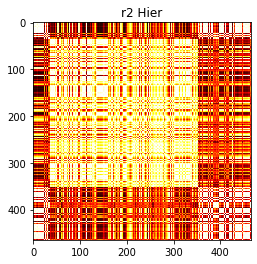

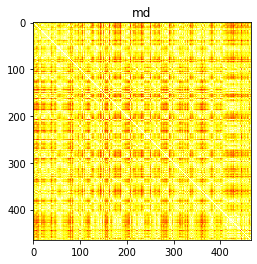

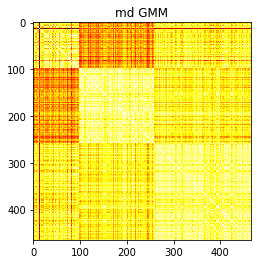

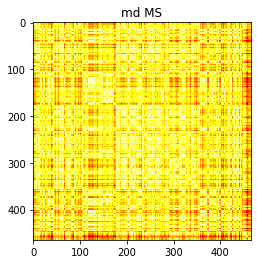

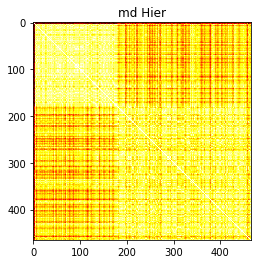

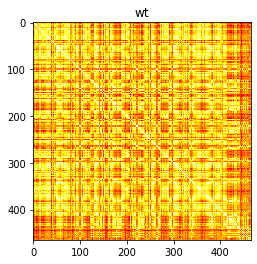

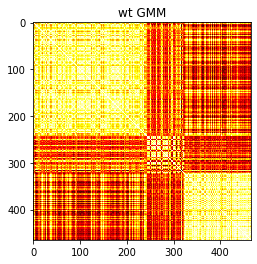

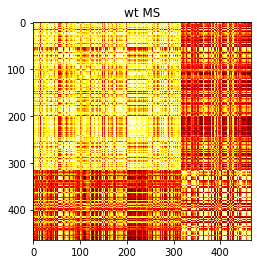

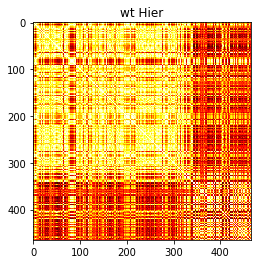

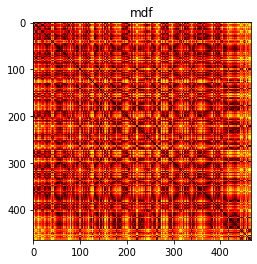

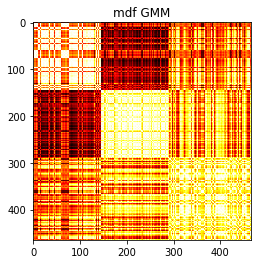

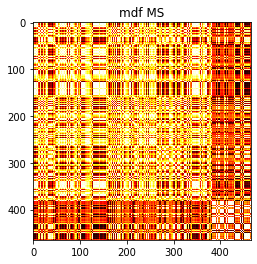

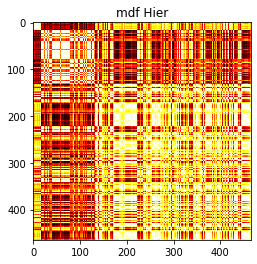

In [17]:
model_idxs = [gmm_idxs, ms_idxs, hier_idxs]
model_names = ['GMM', 'MS', 'Hier']

for name, adjacency in zip(adjacencies_names, adjacencies):
    i = adjacencies_names.index(name)
    
    plt.figure()
    plt.title(f'{name}')
    plt.imshow(adjacency, cmap='hot', interpolation='nearest')
    plt.show()
        
    for model_name, model_idx in zip(model_names, model_idxs):
        columns = [dfs[i].columns.tolist()[j] for j in list((np.argsort(model_idx[i])))]
        clust_df = dfs[i].reindex(columns, axis=1)
        clust_corr = clust_df.corr()

        plt.figure()
        plt.title(f'{name} {model_name}')
        plt.imshow(clust_corr, cmap='hot', interpolation='nearest')
        plt.show()